<a href="https://colab.research.google.com/github/treewithbird/ReadingHelper/blob/main/th2d_data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pyro-ppl

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

### Data generation

In [ ]:
def generate_trial(n=100):

    MONITOR_BORDER_PAD = 0.05  # Available screen size will be square of width H*(1-MONITOR_BORDER_PAD*2)
    TRIAL_BOUNDING_BOX_SIZE = 0.6

    ########################################################################
    # From here, think of available screen is a square from (0, 0) to (1, 1)
    ########################################################################

    # Every trial will fit inside the square of l = TRIAL_BOUNDING_BOX_SIZE
    mu_0 = pyro.param("mu_0", lambda: torch.tensor([
        ############################################
        # value between [0, TRIAL_BOUNDING_BOX_SIZE]
        ############################################
        [0.3, 0.4], # g         [0.3, 0.3], # g
        [0.05, 0.05], # s1      [0.45, 0.15], # s1
        [0.15, 0.55], # m1      [0.35, 0.15], # m1
        [0.55, 0.10], # s2      [0.15, 0.45], # s2
        [0.55, 0.55], # m2      [0.15, 0.35], # m2
        ]), constraint=constraints.real)
    sigma_0 = pyro.param("sigma_0", lambda: torch.tensor(0.01) * torch.eye(2), constraint=constraints.real)

    # sample covariance from categorical distribution
    cov_category = torch.tensor([0.0001, 0.0003, 0.0005])
    s1_cov = cov_category[pyro.sample("s1_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)
    m1_cov = cov_category[pyro.sample("m1_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)
    s2_cov = cov_category[pyro.sample("s2_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)
    m2_cov = cov_category[pyro.sample("m2_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)

    # sample each landmarks
    g = pyro.sample("g", dist.Delta(mu_0[0]))
    with pyro.plate("n", n):
        s1 = pyro.sample("s1", dist.MultivariateNormal(mu_0[1], s1_cov))
        m1 = pyro.sample("m1", dist.MultivariateNormal(mu_0[2], m1_cov))
        s2 = pyro.sample("s2", dist.MultivariateNormal(mu_0[3], s2_cov))
        m2 = pyro.sample("m2", dist.MultivariateNormal(mu_0[4], m2_cov))
        ############################################
        # (g, s1, m1, s2, m2) should all be inside TRIAL_BOUNDING_BOX
        # This will happen after TruncatedMultivariateNormal is implemented
        ############################################

    pads = [torch.max(torch.abs(i))/2 for i in [(m1-s1), (g-m1), (m2-s2), (g-m2)]]
    with pyro.plate("x_and_y", 2):
        # To give different camera noise for each stimuli,
        # enable the following plate.
        with pyro.plate("n_", n):
            c_noise_s1_to_m1 = pyro.sample("cn_s1_to_m1", dist.Uniform(pads[0], 1-pads[0]))
            c_noise_m1_to_g = pyro.sample("cn_m1_to_g", dist.Uniform(pads[1], 1-pads[1]))
            c_noise_s2_to_m2 = pyro.sample("cn_s2_to_m2", dist.Uniform(pads[2], 1-pads[2]))
            c_noise_m2_to_g = pyro.sample("cn_m2_to_g", dist.Uniform(pads[3], 1-pads[3]))

    # Make training stimuli
    centered = [[(b-a)/2, (a-b)/2] for (a, b) in [(m1,s1), (g,m1), (m2,s2), (g,m2)]]

    s1_to_m1 = torch.stack([c_noise_s1_to_m1+centered[0][0], c_noise_s1_to_m1+centered[0][1]])
    m1_to_g = torch.stack([c_noise_m1_to_g+centered[1][0], c_noise_m1_to_g+centered[1][1]])
    s2_to_m2 = torch.stack([c_noise_s2_to_m2+centered[2][0], c_noise_s2_to_m2+centered[2][1]])
    m2_to_g = torch.stack([c_noise_m2_to_g+centered[3][0], c_noise_m2_to_g+centered[3][1]])

    # make testing stimuli
    s1_obs = pyro.sample("s1_obs", dist.MultivariateNormal(mu_0[1], s1_cov))
    s2_obs = pyro.sample("s2_obs", dist.MultivariateNormal(mu_0[3], s2_cov))
    camera_noise_trial = pyro.sample("camera_noise_trial", dist.Uniform(0, 1-TRIAL_BOUNDING_BOX_SIZE))
    s1_obs_to_s2_obs = torch.stack([camera_noise_trial+s1_obs, camera_noise_trial+s2_obs])

    ########################################################################
    # From here, think of available screen is a square from (-1, -1) to (1, 1)
    ########################################################################
    # Scale stimulis to fit the available screen.
    _ret_raw = [g, s1, m1, s2, m2, s1_obs, s2_obs]
    _ret_raw = [i.detach() for i in _ret_raw]
    _ret_raw_to_screen = [(i-TRIAL_BOUNDING_BOX_SIZE/2)*(2-2*MONITOR_BORDER_PAD) for i in _ret_raw]

    _ret = [s1_to_m1, m1_to_g, s2_to_m2, m2_to_g, s1_obs_to_s2_obs]
    _ret = [i.detach() for i in _ret]
    _ret_to_screen = [(i-0.5)*(2-2*MONITOR_BORDER_PAD) for i in _ret]
    return _ret_raw_to_screen, _ret_to_screen

pyro.clear_param_store()
ret_raw, ret = generate_trial(n=11)

g, s1, m1, s2, m2, s1_obs, s2_obs = ret_raw

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title("Centered view")
plt.scatter(*g.T); plt.annotate('g', g.T, fontsize=15)
plt.scatter(*s1.T); plt.annotate('s1', s1[0], fontsize=15)
plt.scatter(*m1.T); plt.annotate('m1', m1[0], fontsize=15)
plt.scatter(*s2.T); plt.annotate('s2', s2[0], fontsize=15)
plt.scatter(*m2.T); plt.annotate('m2', m2[0], fontsize=15)
plt.scatter(*s1_obs.T)
plt.scatter(*s2_obs.T)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.subplot(1, 3, 2)
plt.title("Training phase")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
s1_to_m1, m1_to_g, s2_to_m2, m2_to_g, s1_obs_to_s2_obs = ret
plt.plot(s1_to_m1[:, :, 0], s1_to_m1[:, :, 1], 'orange')
# plt.annotate('s1', s1_to_m1[0, 0, :], fontsize=15)
# plt.annotate('m1', s1_to_m1[1, 0, :], fontsize=15)
plt.plot(m1_to_g[:, :, 0], m1_to_g[:, :, 1], 'g')
# plt.annotate('m1', m1_to_g[0, 0, :], fontsize=15)
# plt.annotate('g', m1_to_g[1, 0, :], fontsize=15)
plt.plot(s2_to_m2[:, :, 0], s2_to_m2[:, :, 1], 'r')
# plt.annotate('s2', s2_to_m2[0, 0, :], fontsize=15)
# plt.annotate('m2', s2_to_m2[1, 0, :], fontsize=15)
plt.plot(m2_to_g[:, :, 0], m2_to_g[:, :, 1], 'purple')
# plt.annotate('m2', m2_to_g[0, 0, :], fontsize=15)
# plt.annotate('g', m2_to_g[1, 0, :], fontsize=15)

plt.subplot(1, 3, 3)
plt.title("Testing phase")
plt.scatter(*s1_obs_to_s2_obs.T)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

# pyro.render_model(
#     generate_trial,
#     model_args=(),
#     render_distributions=True,
#     render_params=True,
#     render_deterministic=True
#     )

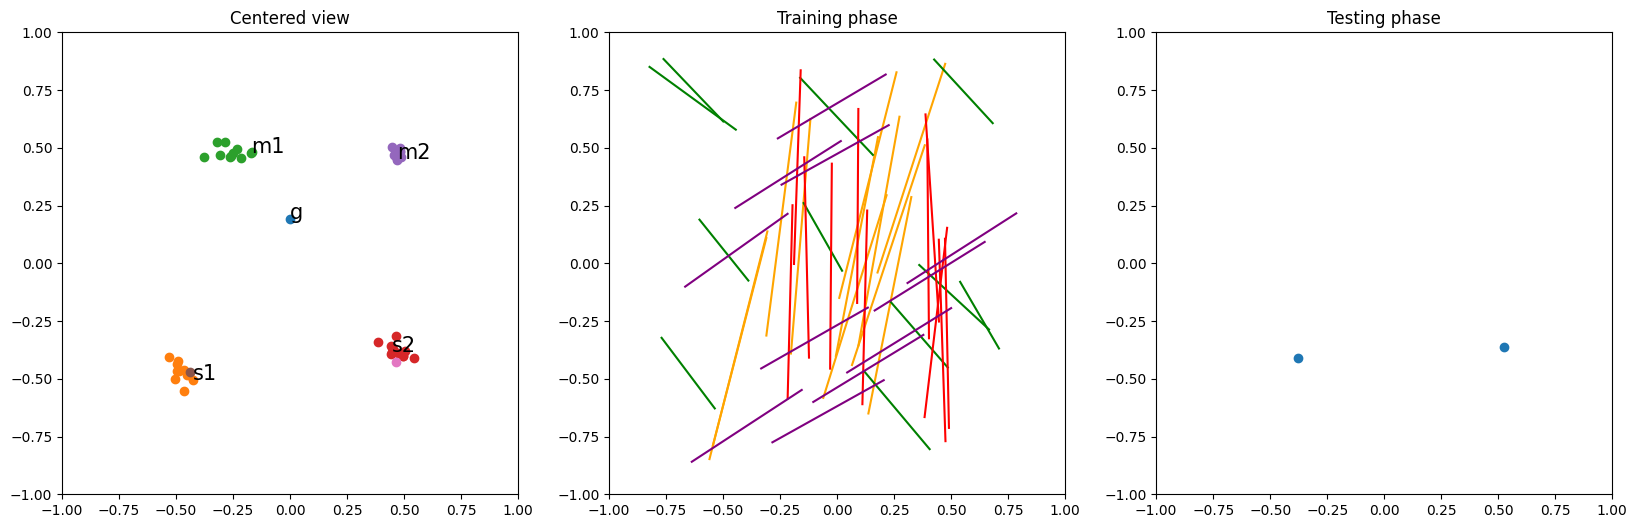

In [ ]:
def generate_trial(n=100):

    MONITOR_BORDER_PAD = 0.05  # Available screen size will be square of width H*(1-MONITOR_BORDER_PAD*2)
    TRIAL_BOUNDING_BOX_SIZE = 0.6

    ########################################################################
    # From here, think of available screen is a square from (0, 0) to (1, 1)
    ########################################################################

    # Every trial will fit inside the square of l = TRIAL_BOUNDING_BOX_SIZE
    mu_0 = pyro.param("mu_0", lambda: torch.tensor([
        ############################################
        # value between [0, TRIAL_BOUNDING_BOX_SIZE]
        ############################################
        [0.3, 0.4], # g         [0.3, 0.3], # g
        [0.05, 0.05], # s1      [0.45, 0.15], # s1
        [0.15, 0.55], # m1      [0.35, 0.15], # m1
        [0.55, 0.10], # s2      [0.15, 0.45], # s2
        [0.55, 0.55], # m2      [0.15, 0.35], # m2
        ]), constraint=constraints.real)
    sigma_0 = pyro.param("sigma_0", lambda: torch.tensor(0.01) * torch.eye(2), constraint=constraints.real)

    # sample covariance from categorical distribution
    cov_category = torch.tensor([0.0001, 0.0003, 0.0005])
    s1_cov = cov_category[pyro.sample("s1_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)
    m1_cov = cov_category[pyro.sample("m1_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)
    s2_cov = cov_category[pyro.sample("s2_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)
    m2_cov = cov_category[pyro.sample("m2_cov", dist.Categorical(torch.tensor([1, 1, 1])))]*torch.eye(2)

    # sample each landmarks
    g = pyro.sample("g", dist.Delta(mu_0[0]))
    with pyro.plate("n", n):
        s1 = pyro.sample("s1", dist.MultivariateNormal(mu_0[1], s1_cov))
        m1 = pyro.sample("m1", dist.MultivariateNormal(mu_0[2], m1_cov))
        s2 = pyro.sample("s2", dist.MultivariateNormal(mu_0[3], s2_cov))
        m2 = pyro.sample("m2", dist.MultivariateNormal(mu_0[4], m2_cov))
        ############################################
        # (g, s1, m1, s2, m2) should all be inside TRIAL_BOUNDING_BOX
        # This will happen after TruncatedMultivariateNormal is implemented
        ############################################

    pads = [torch.max(torch.abs(i))/2 for i in [(m1-s1), (g-m1), (m2-s2), (g-m2)]]
    with pyro.plate("x_and_y", 2):
        # To give different camera noise for each stimuli,
        # enable the following plate.
        with pyro.plate("n_", n):
            c_noise_s1_to_m1 = pyro.sample("cn_s1_to_m1", dist.Uniform(pads[0], 1-pads[0]))
            c_noise_m1_to_g = pyro.sample("cn_m1_to_g", dist.Uniform(pads[1], 1-pads[1]))
            c_noise_s2_to_m2 = pyro.sample("cn_s2_to_m2", dist.Uniform(pads[2], 1-pads[2]))
            c_noise_m2_to_g = pyro.sample("cn_m2_to_g", dist.Uniform(pads[3], 1-pads[3]))

    # Make training stimuli
    centered = [[(b-a)/2, (a-b)/2] for (a, b) in [(m1,s1), (g,m1), (m2,s2), (g,m2)]]

    s1_to_m1 = torch.stack([c_noise_s1_to_m1+centered[0][0], c_noise_s1_to_m1+centered[0][1]])
    m1_to_g = torch.stack([c_noise_m1_to_g+centered[1][0], c_noise_m1_to_g+centered[1][1]])
    s2_to_m2 = torch.stack([c_noise_s2_to_m2+centered[2][0], c_noise_s2_to_m2+centered[2][1]])
    m2_to_g = torch.stack([c_noise_m2_to_g+centered[3][0], c_noise_m2_to_g+centered[3][1]])

    # make testing stimuli
    s1_obs = pyro.sample("s1_obs", dist.MultivariateNormal(mu_0[1], s1_cov))
    s2_obs = pyro.sample("s2_obs", dist.MultivariateNormal(mu_0[3], s2_cov))
    camera_noise_trial = pyro.sample("camera_noise_trial", dist.Uniform(0, 1-TRIAL_BOUNDING_BOX_SIZE))
    s1_obs_to_s2_obs = torch.stack([camera_noise_trial+s1_obs, camera_noise_trial+s2_obs])

    ########################################################################
    # From here, think of available screen is a square from (-1, -1) to (1, 1)
    ########################################################################
    # Scale stimulis to fit the available screen.
    _ret_raw = [g, s1, m1, s2, m2, s1_obs, s2_obs]
    _ret_raw = [i.detach() for i in _ret_raw]
    _ret_raw_to_screen = [(i-TRIAL_BOUNDING_BOX_SIZE/2)*(2-2*MONITOR_BORDER_PAD) for i in _ret_raw]

    _ret = [s1_to_m1, m1_to_g, s2_to_m2, m2_to_g, s1_obs_to_s2_obs]
    _ret = [i.detach() for i in _ret]
    _ret_to_screen = [(i-0.5)*(2-2*MONITOR_BORDER_PAD) for i in _ret]
    return _ret_raw_to_screen, _ret_to_screen

pyro.clear_param_store()
ret_raw, ret = generate_trial(n=11)

g, s1, m1, s2, m2, s1_obs, s2_obs = ret_raw

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title("Centered view")
plt.scatter(*g.T); plt.annotate('g', g.T, fontsize=15)
plt.scatter(*s1.T); plt.annotate('s1', s1[0], fontsize=15)
plt.scatter(*m1.T); plt.annotate('m1', m1[0], fontsize=15)
plt.scatter(*s2.T); plt.annotate('s2', s2[0], fontsize=15)
plt.scatter(*m2.T); plt.annotate('m2', m2[0], fontsize=15)
plt.scatter(*s1_obs.T)
plt.scatter(*s2_obs.T)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.subplot(1, 3, 2)
plt.title("Training phase")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
s1_to_m1, m1_to_g, s2_to_m2, m2_to_g, s1_obs_to_s2_obs = ret
plt.plot(s1_to_m1[:, :, 0], s1_to_m1[:, :, 1], 'orange')
# plt.annotate('s1', s1_to_m1[0, 0, :], fontsize=15)
# plt.annotate('m1', s1_to_m1[1, 0, :], fontsize=15)
plt.plot(m1_to_g[:, :, 0], m1_to_g[:, :, 1], 'g')
# plt.annotate('m1', m1_to_g[0, 0, :], fontsize=15)
# plt.annotate('g', m1_to_g[1, 0, :], fontsize=15)
plt.plot(s2_to_m2[:, :, 0], s2_to_m2[:, :, 1], 'r')
# plt.annotate('s2', s2_to_m2[0, 0, :], fontsize=15)
# plt.annotate('m2', s2_to_m2[1, 0, :], fontsize=15)
plt.plot(m2_to_g[:, :, 0], m2_to_g[:, :, 1], 'purple')
# plt.annotate('m2', m2_to_g[0, 0, :], fontsize=15)
# plt.annotate('g', m2_to_g[1, 0, :], fontsize=15)

plt.subplot(1, 3, 3)
plt.title("Testing phase")
plt.scatter(*s1_obs_to_s2_obs.T)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

# pyro.render_model(
#     generate_trial,
#     model_args=(),
#     render_distributions=True,
#     render_params=True,
#     render_deterministic=True
#     )